In [31]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import folium
import h3
pd.options.mode.copy_on_write = True

In [32]:
offer= pd.read_csv("./datasets/data_offers.csv")
offer.head()

,order_gk,offer_id
0,3000579625629,300050936206
1,3000627306450,300052064651
2,3000632920686,300052408812
3,3000632771725,300052393030
4,3000583467642,300051001196


In [33]:
order= pd.read_csv("./datasets/data_orders.csv")
order.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0
4,21:24:45,-0.967605,51.458236,NaN,3000583140877,9,0,NaN


## Q1

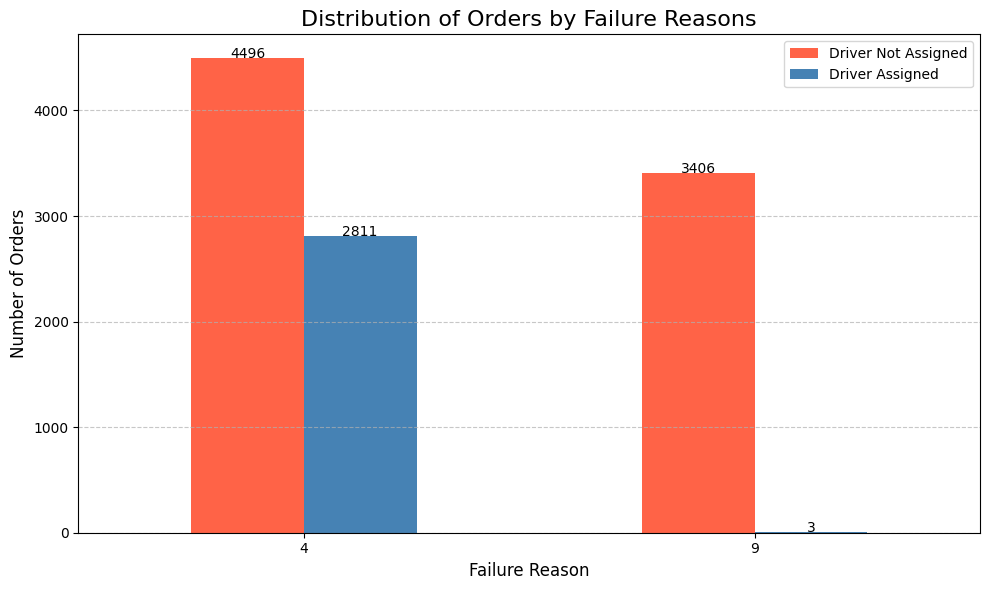

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

# 分类数据
fail_reason_counts = order.groupby(['order_status_key', 'is_driver_assigned_key']).size().unstack(fill_value=0)

# 画图
ax = fail_reason_counts.plot(kind='bar', stacked=False, figsize=(10, 6), color=['#FF6347', '#4682B4']) 
plt.title('Distribution of Orders by Failure Reasons', fontsize=16)  
plt.xlabel('Failure Reason', fontsize=12)  
plt.ylabel('Number of Orders', fontsize=12)  
plt.xticks(rotation=0, fontsize=10)  
plt.yticks(fontsize=10)  
plt.grid(axis='y', linestyle='--', alpha=0.7) 
plt.legend(['Driver Not Assigned', 'Driver Assigned'], fontsize=10)  

for i in ax.patches:
    ax.text(i.get_x() + i.get_width() / 2, i.get_height() + 0.5, str(int(i.get_height())), ha='center', fontsize=10)

plt.tight_layout()
plt.show()


Then we can easily find that the type without assigning a driver and cancelling by client gets the highest number.

## Q2

In [63]:
# Filtering failed orders
failed_orders = order[(order['order_status_key'] == 4) | (order['order_status_key'] == 9)]

# Converting order_datetime column to datetime format
failed_orders['order_datetime'] = pd.to_datetime(failed_orders['order_datetime'])

# Grouping by hour and counting
failed_orders_by_hour = failed_orders.pivot_table(index=failed_orders['order_datetime'].dt.hour, columns=['order_status_key', 'is_driver_assigned_key'], aggfunc='size', fill_value=0)
failed_orders_by_hour.head(2)

order_status_key          4         9   
is_driver_assigned_key    0    1    0  1
order_datetime                          
0                       298  120  263  2
1                       219   88  164  0

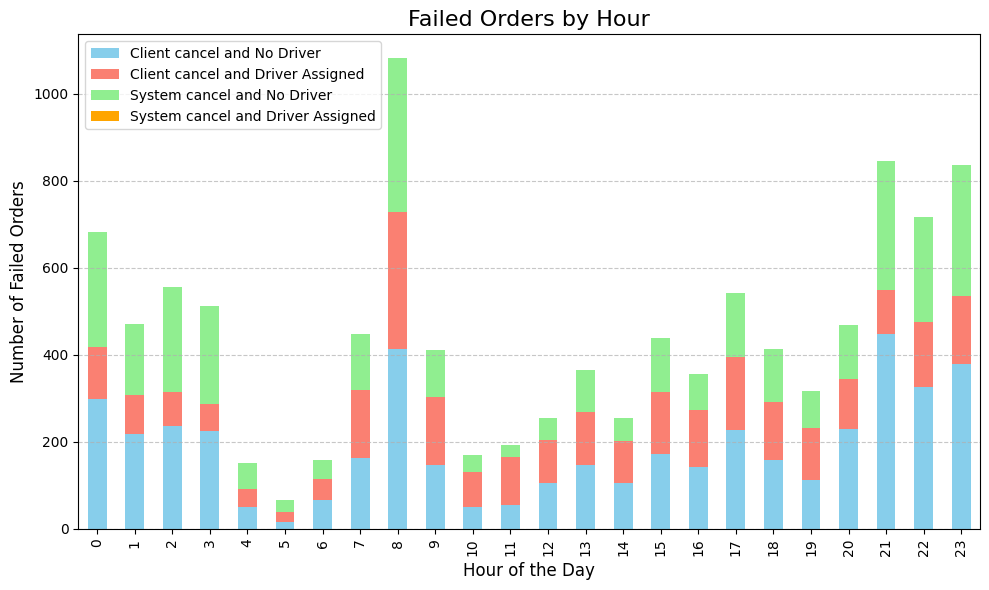

In [75]:
# plot
colors = ['skyblue', 'salmon', 'lightgreen', 'orange']
fig, ax = plt.subplots(figsize=(10, 6))
ax = failed_orders_by_hour.plot(kind='bar', stacked=True, color=colors,ax=ax)

plt.title('Failed Orders by Hour', fontsize=16)
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('Number of Failed Orders', fontsize=12)

# 调整图例的位置和字体大小
plt.legend(fontsize=10, title_fontsize=10, loc='upper left',labels=labels)

# 添加网格线
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# 调整坐标轴刻度字体大小
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()  

plt.show()


- I observe high total failure order numbers during the time intervals of 0-3, 7-9, and 21-23. 

- And the number of No Driver and Client Cancel has siginificant increase in 0-3, 7-9 and 21-23.

- For the reason, I think people need taxis to go to work or home during those periods.


## Q3

In [78]:
# Filtering canceled orders with and without drivers
cancelled_with_driver = order[(order['is_driver_assigned_key'] == 1) & (order['order_status_key'] == 4)]
cancelled_without_driver = order[(order['is_driver_assigned_key'] == 0) & (order['order_status_key'] == 4)]
cancelled_with_driver['order_datetime'] = pd.to_datetime(cancelled_with_driver['order_datetime'])
cancelled_without_driver['order_datetime'] = pd.to_datetime(cancelled_without_driver['order_datetime'])

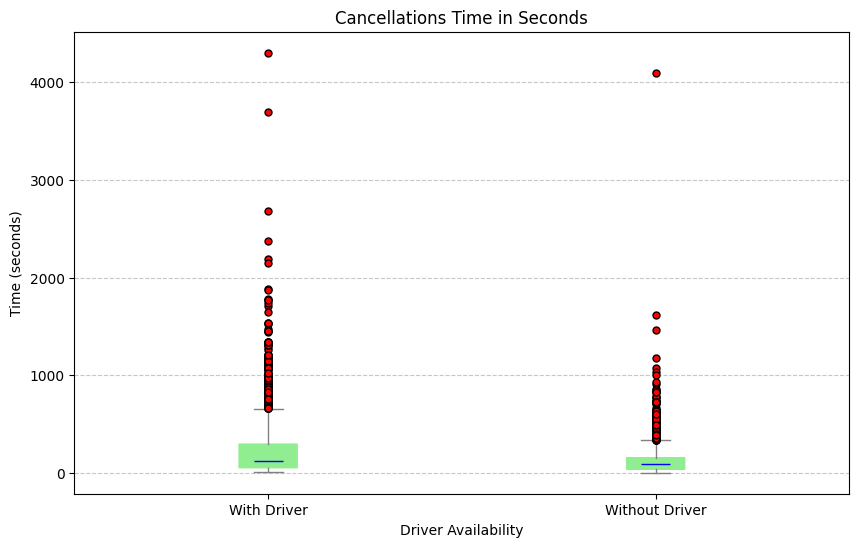

In [82]:
plt.figure(figsize=(10, 6))

# 绘制箱线图，并指定颜色、标记等参数
plt.boxplot([cancelled_with_driver["cancellations_time_in_seconds"], cancelled_without_driver["cancellations_time_in_seconds"]],
            labels=['With Driver', 'Without Driver'],
            patch_artist=True,  # 使用填充颜色
            notch=True,         # 使用凹口
            medianprops={'color': 'blue'},  # 中位数线的颜色
            boxprops={'color': 'lightgreen', 'facecolor': 'lightgreen'},  # 箱体的颜色
            whiskerprops={'color': 'gray'},  # 箱线的颜色
            capprops={'color': 'gray'},      # 箱线末端线段的颜色
            flierprops={'marker': 'o', 'markerfacecolor': 'red', 'markersize': 5}  # 异常值的标记
           )

plt.title('Cancellations Time in Seconds')
plt.xlabel('Driver Availability')
plt.ylabel('Time (seconds)')

plt.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.show()


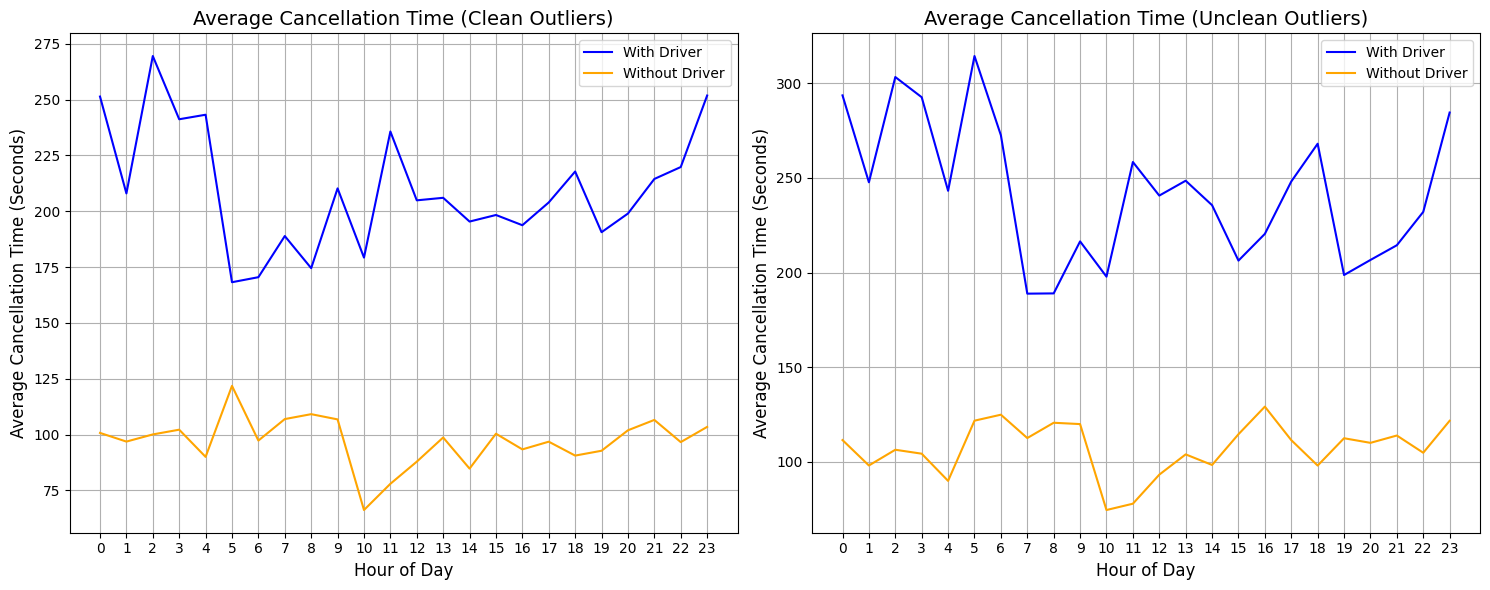

In [84]:
# Eliminating outliers
cancelled_with_driver_clean = cancelled_with_driver[cancelled_with_driver['cancellations_time_in_seconds'] < cancelled_with_driver['cancellations_time_in_seconds'].quantile(0.98)]
cancelled_without_driver_clean = cancelled_without_driver[cancelled_without_driver['cancellations_time_in_seconds'] < cancelled_without_driver['cancellations_time_in_seconds'].quantile(0.98)]

# Calculating average cancellation time
avg_cancel_time_with_driver = cancelled_with_driver.groupby(cancelled_with_driver['order_datetime'].dt.hour)['cancellations_time_in_seconds'].mean()
avg_cancel_time_without_driver = cancelled_without_driver.groupby(cancelled_without_driver['order_datetime'].dt.hour)['cancellations_time_in_seconds'].mean()

# Calculating average cancellation time after eliminating outliers
avg_cancel_time_with_driver_clean = cancelled_with_driver_clean.groupby(cancelled_with_driver_clean['order_datetime'].dt.hour)['cancellations_time_in_seconds'].mean()
avg_cancel_time_without_driver_clean = cancelled_without_driver_clean.groupby(cancelled_without_driver_clean['order_datetime'].dt.hour)['cancellations_time_in_seconds'].mean()

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Left plot: Cleaned data
axs[0].plot(avg_cancel_time_with_driver_clean.index, avg_cancel_time_with_driver_clean.values, label='With Driver', color='blue')
axs[0].plot(avg_cancel_time_without_driver_clean.index, avg_cancel_time_without_driver_clean.values, label='Without Driver', color='orange')
axs[0].set_title('Average Cancellation Time (Clean Outliers)', fontsize=14)
axs[0].set_xlabel('Hour of Day', fontsize=12)
axs[0].set_ylabel('Average Cancellation Time (Seconds)', fontsize=12)
axs[0].set_xticks(range(24))
axs[0].legend()
axs[0].grid(True)

# Right plot: Uncleaned data
axs[1].plot(avg_cancel_time_with_driver.index, avg_cancel_time_with_driver.values, label='With Driver', color='blue')
axs[1].plot(avg_cancel_time_without_driver.index, avg_cancel_time_without_driver.values, label='Without Driver', color='orange')
axs[1].set_title('Average Cancellation Time (Unclean Outliers)', fontsize=14)
axs[1].set_xlabel('Hour of Day', fontsize=12)
axs[1].set_ylabel('Average Cancellation Time (Seconds)', fontsize=12)
axs[1].set_xticks(range(24))
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


- From the Box-plots, we can know there are some outliers in the dataset, especially in the order with a driver. And after filter them, the line is more flat.
- And the average time of the orders with a driver are much longer than without a driver. Maybe people tend to spend some time when there is hope.

## Q4

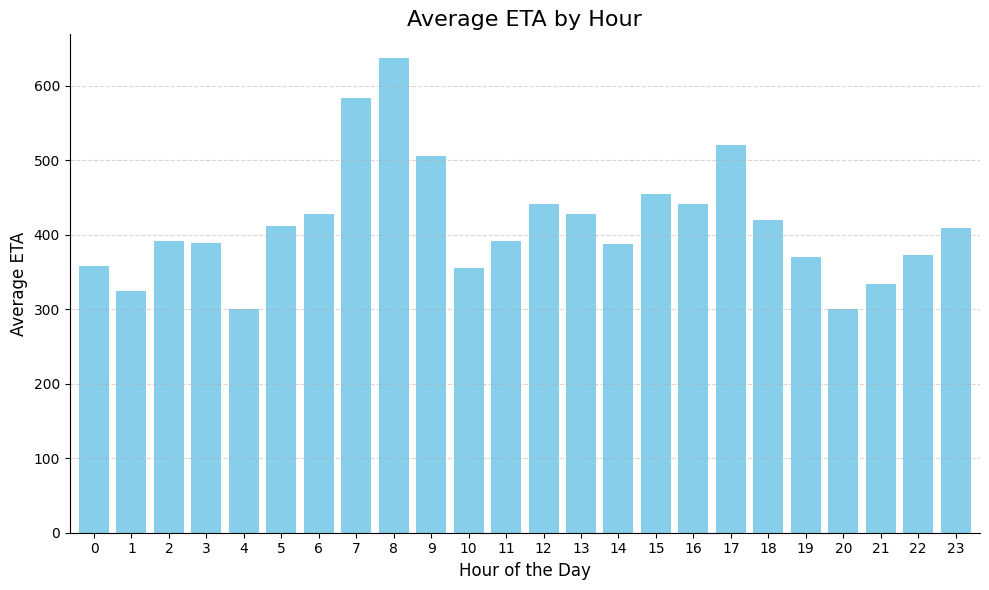

In [12]:
# Converting order_datetime column to datetime format
order['order_datetime'] = pd.to_datetime(order['order_datetime'])

# Grouping by hour and calculating average ETA
hourly_avg_eta = order.groupby(order['order_datetime'].dt.hour)['m_order_eta'].mean()

# Plotting
plt.figure(figsize=(10, 6))
hourly_avg_eta.plot(kind='bar', color='skyblue', width=0.8)  # Adjusting bar width for aesthetics
plt.title('Average ETA by Hour', fontsize=16)
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('Average ETA', fontsize=12)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.5)  
plt.gca().spines['top'].set_visible(False)  
plt.gca().spines['right'].set_visible(False) 
plt.tight_layout()
plt.show()

- The average ETA in different hours are mostly around 400. For the reason, I think people always take a taxi when they go to some places that are about the same distances.
- Also the average ETA tends to increase in 7-9 AM and 5-6 PM throughout the day, maybe lots of people need to commute and the roads are quite congested.

## Q5

In [14]:
# Compute the area
order['h3_index'] = order.apply(lambda row: h3.geo_to_h3(row['origin_latitude'], row['origin_longitude'], 8), axis=1)
hex_counts = order['h3_index'].value_counts().reset_index()
hex_counts.columns = ['h3_index', 'order_count']
hex_counts_sorted = hex_counts.sort_values(by='order_count', ascending=False)
hex_counts_sorted['cumulative_sum'] = hex_counts_sorted['order_count'].cumsum()
total_orders = hex_counts_sorted['order_count'].sum()
target_orders = total_orders * 0.8
target_hexes = hex_counts_sorted[hex_counts_sorted['cumulative_sum'] <= target_orders]
target_hex_indexes = target_hexes['h3_index'].tolist()
target_hexes.head()

,h3_index,order_count,cumulative_sum
0,88195d2b1dfffff,1497,1497
1,88195d2b1bfffff,870,2367
2,88195d2b15fffff,774,3141
3,88195d2b11fffff,707,3848
4,88195d2b19fffff,667,4515


In [22]:
# Get min and max order counts for color range
min_count = target_hexes['order_count'].min()
max_count = target_hexes['order_count'].max()


color_range = ['#FFDAB9', '#8B0000']

# Create a linear colormap
colormap = folium.LinearColormap(colors=color_range, vmin=min_count, vmax=max_count)
loc = h3.h3_to_geo_boundary(target_hex_indexes[0])[0]
# Initialize a folium map
m = folium.Map(location=loc,zoom_start=12)

for hex_index in target_hex_indexes:
    # Get coordinates for the vertices of the hexagon
    vertices = h3.h3_to_geo_boundary(hex_index)
    
    # Create a list of latitudes and longitudes for the vertices
    lat_lng = [[vertex[0], vertex[1]] for vertex in vertices]
    
    # Get order count for the hexagon
    order_count = target_hexes[target_hexes['h3_index'] == hex_index]['order_count'].item()
    
    # Choose color from colormap based on order count
    color = colormap(order_count)
    
    # Create a folium polygon for the hexagon and add it to the map
    folium.Polygon(locations=lat_lng, color=color, fill=True, fill_color=color,popup=order_count,tooltip="Orders",fill_opacity=0.6).add_to(m)

colormap.caption = 'Order Count'
m.add_child(colormap)

display(m)